In [3]:
import pandas as pd
import numpy as np
import operator

from tqdm import tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pylab 

import spacy
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE 
from sklearn.metrics import pairwise_distances_argmin_min

In [4]:
nlp = spacy.load('en_core_web_lg')
np.random.seed(42)

# 1. Load Data

In [5]:
# df = pd.read_csv('../data/nyt_data_20200202.csv')

df = pd.read_csv('../data/news_api.csv')

In [6]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'])

df = df.drop_duplicates()

In [7]:
df.head()

,author,content,description,publishedAt,source,title,url,urlToImage
0,https://www.facebook.com/bbcnews,Image copyrightGetty ImagesImage caption\r\n W...,Hundreds of Muslim women are braving the Delhi...,2020-01-04 01:14:44,"{'id': 'bbc-news', 'name': 'BBC News'}",Shaheen Bagh: The women occupying Delhi street...,https://www.bbc.co.uk/news/world-asia-india-50...,https://ichef.bbci.co.uk/news/1024/branded_new...
1,https://www.facebook.com/bbcnews,Image caption\r\n Callum has travelled to Roya...,The community in Shetland is trying to raise m...,2020-01-04 01:04:57,"{'id': 'bbc-news', 'name': 'BBC News'}","'I need to go on a car, a boat, a plane and a ...",https://www.bbc.co.uk/news/uk-scotland-north-e...,https://ichef.bbci.co.uk/news/1024/branded_new...
2,https://www.facebook.com/bbcnews,Image copyrightGetty Images\r\nPatients who fa...,GPs urge hospitals not to strike people off th...,2020-01-04 01:35:46,"{'id': 'bbc-news', 'name': 'BBC News'}",Call to give hospital appointment no-shows sec...,https://www.bbc.co.uk/news/uk-wales-49263455,https://ichef.bbci.co.uk/news/1024/branded_new...
3,https://www.facebook.com/bbcnews,Image copyrightGetty Images\r\nThey were said ...,Figures show millions of the new-style £5 and ...,2020-01-04 03:57:47,"{'id': 'bbc-news', 'name': 'BBC News'}",Millions of plastic £5 and £10 banknotes repla...,https://www.bbc.co.uk/news/uk-50989914,https://ichef.bbci.co.uk/news/1024/branded_new...
4,BBC News,NaN,The increasing age of carers looking after adu...,2020-01-04 00:01:04,"{'id': 'bbc-news', 'name': 'BBC News'}",Age of carers is 'looming crisis' for adult care,https://www.bbc.co.uk/news/av/uk-england-hamps...,https://ichef.bbci.co.uk/news/1024/branded_new...


# 2. Text Analysis

To give meaning to independent words and, consequently, whole sentences, we’ll use SpaCy’s pre-trained word embeddings models. More specifically, SpaCy’s large model (en_core_web_lg), which has pre-trained word vectors for 685k English words. Alternatively, you could be using any pre-trained word representation model (Word2Vec, FastText, GloVe…).

By default, SpaCy considers a sentence’s vector as the average between every word’s vector. It’s a simplistic approach that doesn’t take into account the order of words to determine a sentence’s vector.

In [8]:
sent_vecs = {}
docs = []

for title in tqdm_notebook(df.title):
    doc = nlp(title)
    docs.append(doc)
    sent_vecs.update({title: doc.vector})

sentences = list(sent_vecs.keys())
vectors = list(sent_vecs.values())

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


# 3. Clustering

The epsilon parameter determines the maximum distance between two samples for them to be considered as in the same neighborhood, meaning that if eps is too big, fewer clusters will be formed, but also if it’s too small, most of the points will be classified as not belonging to a cluster (-1), which will result in a few clusters as well.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [9]:
x = np.array(vectors)

n_classes = {}

for i in tqdm_notebook(np.arange(0.001, 1, 0.001)):
    dbscan = DBSCAN(eps=i,
                    min_samples=2,
                    metric='cosine',
                    n_jobs=-1).fit(x)
    n_classes.update({i: len(pd.Series(dbscan.labels_).value_counts())})

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


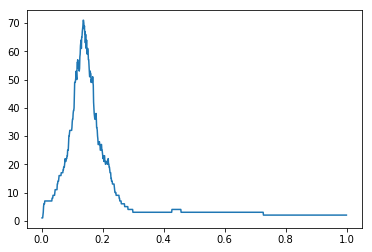

In [10]:
plt.plot(list(n_classes.keys()), list(n_classes.values()))
plt.show()

Tunning eps value might be one of the most delicate steps because the outcome will vary a lot depending on how much you want to consider sentences as similar. The right value will come up with experimentation, trying to find a value that preserves the similarities between sentences without splitting close sentences into different groups.

In general, since we want to end up with very similar sentences in the same cluster, the target should be a value that returns a higher number of classes

In [11]:
max_eps = max(n_classes.items(), key=operator.itemgetter(1))[0]

dbscan = DBSCAN(eps=max_eps,
                min_samples=5,
                metric='cosine').fit(x)
dbscan

DBSCAN(algorithm='auto', eps=0.136, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

In [12]:
result = pd.DataFrame({'label': dbscan.labels_,
                       'sent': sentences
                      })
result.loc[:, 'vectors'] = [x.tolist()]

# 4. Visualize

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [13]:
# reduce dimensions to 2
tsne_coord = TSNE(n_components=2,
             n_jobs=-1).fit_transform(x)

x_tsne, y_tsne = [i[0] for i in tsne_coord], [i[1] for i in tsne_coord]

result['x'] = x_tsne
result['y'] = y_tsne

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [ ]:
result.head()

In [ ]:
# remove un-clustered rows
result_filtered = result[result['label'] != -1]
result_filtered.shape, result.shape

In [ ]:
result_filtered.loc[:, 'lable_cat'] = result_filtered.label.astype(str)
result_filtered.loc[:, 'lable_cat'] = 'g_' + result_filtered['lable_cat'] 

In [ ]:
def generate_color_map(num_color):

    cm = pylab.get_cmap('gist_rainbow')
    cgen = (cm(1.*i/num_color) for i in range(num_color))
    return [i for i in cgen]

c_map = generate_color_map(result_filtered.label.nunique())

In [ ]:
plt.figure(figsize=[16, 16])
sns.scatterplot(x='x', y='y', data=result_filtered,
               hue='lable_cat',
               sizes  = 30,
                palette=c_map
               )

# 5. Transform to Events

Next step is to arrange those sentences in time and to filter them by relevance. 

Since there are many titles about the same topic every day, we need a criterium to pick one among them. It should be the sentence that best represents the event, one that comprises the core message which those titles refer to.

In order to achieve that, we can group the daily sentences, and for each group (or cluster), choose the one closest to the cluster center.

In [ ]:
result_filtered[result_filtered['label'] == 3]

In [ ]:
def get_mean_vector(sents):
    a = np.zeros(300)
    for sent in sents:
        a = a+nlp(sent).vector
    return a/len(sents)


def get_central_vector(sents):
   
    sents = sents.reset_index(drop=True)
    vecs = []
    for sent in sents:
        doc = nlp(sent)
        vecs.append(doc.vector)
        
    mean_vec = get_mean_vector(sents)
    index = pairwise_distances_argmin_min(np.array([mean_vec]),
                                          vecs)[0][0]
    return sents[index]

In [ ]:
get_central_vector(result_filtered['sent'][result_filtered['label'] == 3])